In [1]:
from fastai.conv_learner import *
from fastai.dataset import *
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import matplotlib.pyplot as plt
import math

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
TRAIN = './input/train/'
TEST = './input/test/'
LABELS = './input/train.csv'
SAMPLE_SUB = './input/sample_submission.csv'

In [3]:
train_df = pd.read_csv(LABELS).set_index('Image')
unique_labels = np.unique(train_df.Id.values)
labels_dict = dict()
labels_list = []
for i in range(len(unique_labels)):
    labels_dict[unique_labels[i]] = i
    labels_list.append(unique_labels[i])
print("Number of classes: {}".format(len(unique_labels)))
train_names = train_df.index.values
train_df.Id = train_df.Id.apply(lambda x: labels_dict[x])
train_labels = np.asarray(train_df.Id.values)
test_names = [f for f in os.listdir(TEST)]
labels_count = train_df.Id.value_counts()
dup = []
for idx,row in train_df.iterrows():
    if labels_count[row['Id']] < 5:
        dup.extend([idx]*math.ceil((5 - labels_count[row['Id']])/labels_count[row['Id']]))
train_names = np.concatenate([train_names, dup])
train_names = train_names[np.random.RandomState(seed=42).permutation(train_names.shape[0])]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42069)
split = sss.split(train_names, np.zeros(train_names.shape))
train_indexes = []
val_indexes = []
for train_idx, val_idx in sss.split(train_names, np.zeros(train_names.shape)):
    train_indexes = train_idx
    val_indexes = val_idx
tr_n = [train_names[i] for i in train_indexes]
val_n = [train_names[i] for i in val_indexes]

Number of classes: 5005


In [36]:
class HWIDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.train_df = train_df
        super().__init__(fnames, transform, path)

    def get_x(self, i):
        img = open_image(os.path.join(self.path, self.fnames[i]))
        # We crop the center of the original image for faster training time
        img = cv2.resize(img, (self.sz, self.sz))
        return img

    def get_y(self, i):
        if (self.path == TEST): return 0
        return self.train_df.loc[self.fnames[i]]['Id']


    def get_c(self):
        return len(unique_labels)
def get_data_aug(sz, bs):
    aug_tfms = [RandomRotate(deg=30),
                RandomZoom(zoom_max=1.5, zoom_min=0.8),
                RandomCrop(sz),
                RandomFlip()]
    
    tfms = tfms_from_model(resnet18, sz, crop_type=CropType.RANDOM, aug_tfms=aug_tfms)
    
    ds = ImageData.get_ds(HWIDataset, (tr_n[:-(len(tr_n) % bs)], TRAIN),
                          (val_n, TRAIN), tfms, test=(test_names, TEST))
    md = ImageData("./", ds, bs, num_workers=8, classes=None)
    return md

In [37]:
data = get_data_aug(300, 64)
learn = ConvLearner.pretrained(resnet18, data) 
learn.opt_fn = optim.Adam

In [38]:
learn.load("7_resnet19_im_4_20_10_cyc_0")

In [47]:
preds = learn.predict()

In [49]:
mypreds = np.argmax(preds, axis=1)

In [50]:
mypreds

array([   0, 1651,    0, ...,    0,    0, 2559])

In [55]:
expected = np.array(train_df.loc[train_names[val_indexes]].Id)

In [56]:
expected

array([2283, 1651,    0, ...,  655,  711,  672])

In [58]:
mypreds.shape

(8318,)

In [59]:
expected.shape

(8318,)

In [61]:
accuracy_np(preds, expected)

0.40129838903582593

In [32]:
train_df.loc[train_names[val_indexes[1]]]

Id    1651
Name: 627dd7a49.jpg, dtype: int64

In [62]:
def check_validation_accuracy():
    preds = learn.predict()
    target = np.array(train_df.loc[train_names[val_indexes]].Id)
    return accuracy_np(preds, target)

In [63]:
learn.freeze_all_but(-2)

In [64]:
learn.fit(1e-4, 1)

epoch      trn_loss   val_loss   accuracy                    
    0      5.410397   4.666059   0.323876  



[4.666059115323404, 0.32387593162119976]

In [39]:
x, y = next(iter(data.val_dl))

In [40]:
y

tensor([2283, 1651,    0,    0,    0, 1663,    0, 1255, 3854,    0, 4416, 4831,
         463, 1453, 4761,    0,  175,    0,  371, 3169, 1879, 4675, 4739, 1300,
        4214,  740, 3896,  826,  278, 1051, 2375,  561,    0,    0, 2398,    0,
           0,    0, 1595,    0,   79,  679, 3406, 3366,  121, 1728, 1257, 4394,
        2828, 3090,   64, 1977, 1280, 3971,  377, 3349, 4907, 4010,  655,  832,
           0, 1198,    0, 1333], device='cuda:0')

<bound method ConvLearner.pretrained of <class 'fastai.conv_learner.ConvLearner'>>

In [66]:
trn_tfms, val_tfms = tfms_from_model(resnet18, 300)

In [73]:
img = x[0]

In [85]:
img.shape

torch.Size([3, 300, 300])

In [124]:
train_df.index[0]

'0000e88ab.jpg'

In [126]:
train_df.iloc[0]

Id    4786
Name: 0000e88ab.jpg, dtype: int64

In [127]:
path = f"{TRAIN}{train_df.index[0]}"

In [128]:
path

'./input/train/0000e88ab.jpg'

In [129]:
img = open_image(path)

In [130]:
im = val_tfms(img)

In [132]:
preds = learn.predict_array(im[None])

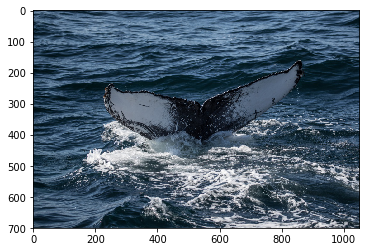

In [135]:
plt.imshow(img)

In [143]:
print(np.argmax(preds), train_df.iloc[0].Id)

4786 4786


In [86]:
imnp = to_np(img)

In [87]:
imnp.shape

(3, 300, 300)

TypeError: Invalid dimensions for image data

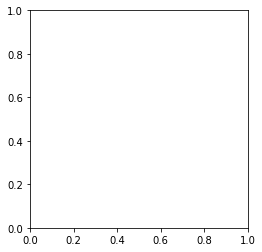

In [90]:
plt.imshow(imnp[None])

In [74]:
p = learn.predict_array(img[None])

OSError: Not valid numpy array

In [42]:
y.shape

torch.Size([64])

In [46]:
p = learn.predict_array(np.array(x[0]))

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 7, 7], but got input of size [3, 300, 300] instead